# 神经网络简单案例研究

罗周杨 20180906

使用softmax线性分类器对数据进行分类，染回实现一个简单的神经网络来分类。

## 生成一些数据

生成一些数据，这些数据不太容易线性分类。


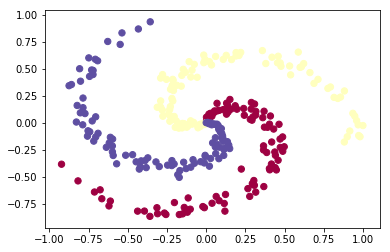

In [5]:
import numpy as np
import matplotlib.pyplot as plt

N = 100 # 每一个类别的生成的点的数量
D = 2 # 每个点的维度，这里使用平面，所以是2维数据
K = 3 # 类别数量，我们一共生成3个类别的点

# 所有的样本数据，一共300个点，每个点用2个维度表示
# 所有训练数据就是一个300*2的二维矩阵
X = np.zeros((N*K, D))
# 标签数据，一共是300个点，每个点对应一个类别，
# 所以标签是一个300*1的矩阵
y = np.zeros(N*K, dtype='uint8')

# 生成训练数据
for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


## 训练一个Softmax线性分类器

使用softmax和cross-entropy loss，训练一个线性分类器。

实际上就是直接用softmax做多分类，使用交叉熵损失作为损失函数，训练一个线性分类模型。


iteration    0 loss: 1.097993
iteration   10 loss: 0.908688
iteration   20 loss: 0.838372
iteration   30 loss: 0.806482
iteration   40 loss: 0.789911
iteration   50 loss: 0.780488
iteration   60 loss: 0.774783
iteration   70 loss: 0.771169
iteration   80 loss: 0.768801
iteration   90 loss: 0.767208
iteration  100 loss: 0.766114
iteration  110 loss: 0.765351
iteration  120 loss: 0.764811
iteration  130 loss: 0.764425
iteration  140 loss: 0.764147
iteration  150 loss: 0.763945
iteration  160 loss: 0.763797
iteration  170 loss: 0.763688
iteration  180 loss: 0.763608
iteration  190 loss: 0.763548
Training accuracy: 0.51


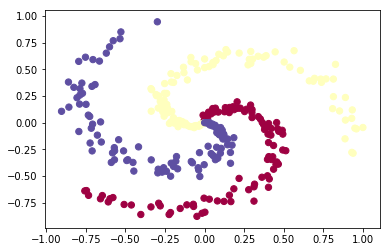

In [11]:
import numpy as np
import matplotlib.pyplot as plt

N = 100
D = 2
K = 3
X = np.zeros((N*K, D))
y = np.zeros(N*K, dtype='uint8')

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
    
# plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
# plt.show()

# 初始化权重和偏置
W = 0.01 * np.random.randn(D, K)
b = np.zeros((1, K))

step_size = 1e-0
reg = 1e-3 # regularization strength


# 获取训练样本数量
num_examples = X.shape[0]

for i in range(200):

    # 计算分类得分
    scores = np.dot(X, W) + b

    # 计算 softmax得分
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # 使用交叉熵损失
    correct_log_probs = -np.log(probs[range(num_examples), y])

    # 计算训练集的data loss，总的损失除以样本数量
    data_loss = np.sum(correct_log_probs) / num_examples
    # 计算正则项损失reg loss，使用L2正则
    # reg就是lambda
    reg_loss = 0.5 * reg * np.sum(W * W)
    # 计算总的损失函数
    loss = data_loss + reg_loss
    
    if i%10 == 0:
        print("iteration %4d loss: %f" % (i, loss))

    # 计算梯度，反向传播
    # 为什么 dscores = probs ??
    dscores = probs
    dscores[range(num_examples), y] -= 1
    dscores /= num_examples

    dW = np.dot(X.T, dscores)
    db = np.sum(dscores, axis=0, keepdims=True)
    dW += reg * W # 正则项的梯度，dW不是第一次出现，必须累加

    # 更新参数
    W += -step_size * dW
    b += -step_size * db

    
# 训练结束，估算准确率
scores = np.dot(X, W) + b
# 在第二个维度（类别维度）取出概率最高的分类
predicted_class = np.argmax(scores, axis=1)
print("Training accuracy: %.2f" % (np.mean(predicted_class == y)))



### 上面代码中，有一个疑问：为什么`dscores = probs`?

Softmax函数得到的是一个归一化后的概率向量，我们用 $p_k$表示类别为k的概率。那么：

$$p_k = \frac{e^{f_k}}{\sum_je^{f_j}}$$

那么我们的交叉熵损失为：

$$L_i = -\log(p_{y_i})$$

那么，有：

$$\frac{\partial L_i }{ \partial f_k } = p_k - \mathbb{1}(y_i = k)$$

这个式子表明：**增加正确分类的分数，可以使得损失降低**！

假设概率向量

$$p=[0.2, 0.3, 0.5]$$

并且第二个0.3是正确分类的概率值。那么我们的梯度是怎么样的呢？

根据上面的公式，只有在正确分类处，梯度变成原来分类概率`-1`，其他位置，梯度就等于原来的分类概率，也就是：

$$df = [0.2, -0.7, 0.5]$$

而这里的**f不就是我们的scores函数**吗？

也就是说

$$dscores = df = probs(y_i != k)$$

那么，对于$y_i=k$的地方，我们$-1$就好了。

于是，我们有了以下公式：

```python
# 一般情况下的df，也就是dscores
dscores = probs
# 预测分类正好是正确分类的情况，需要在该位置的梯度值减去1
dscores[range(num_examples), y] -= 1
# 平均
dscores /= num_examples

```

总之，这是因为softmax这个函数自身的性质！！！


可以看到，正确率只有 `0.5１`。

也算是预料之中，因为数据本来线性特征就不明显。强行上线性分类器，当然效果不佳了。

斯坦福cs231n有一个图，展示了这个模型的决策边界：

![softmax_linear_classify](images/softmax_linear_classify.png)


## 训练一个神经网络

上面的softmax线性分类器效果不佳，我们训练一个神经网络试试看。

代码如下：


In [18]:
import numpy as np

N = 100
D = 2
K = 3

X = np.zeros((N*K, D))
y = np.zeros(N*K, dtype='uint8')

for j in range(K):
    ix = range(N*j, N*(j+1))
    r = np.linspace(0.0, 1, N)
    t = np.linspace(j*4, (j+1)*4, N) + np.random.randn(N)*0.2
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j

h = 100 # 隐藏层的神经元数量

# 第一个层的权重和偏置初始化
W1 = 0.01 * np.random.randn(D, h)
b1 = np.zeros((1, h))

# 第二层的权重和偏置初始化
W2 = 0.01 * np.random.randn(h, K)
b2 = np.zeros((1, K))

step_size = 1e-0
reg = 1e-3 # regularization strength

# 获取训练样本数量
num_examples = X.shape[0]

for i in range(10000):

    # 计算第一个隐藏层的输出，使用ReLU激活函数
    hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
    # 计算输出层的结果，也就是最终的分类得分
    scores = np.dot(hidden_layer, W2) + b2
    
    # softmax
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) # [N x K]
  
    # 计算损失，和之前的一样
    correct_logprobs = -np.log(probs[range(num_examples),y])
    data_loss = np.sum(correct_logprobs) / num_examples
    reg_loss = 0.5 * reg * np.sum(W1 * W1) + 0.5 * reg * np.sum(W2 * W2)
    loss = data_loss + reg_loss
    
    if i % 1000 == 0:
        print ("iteration %4d loss %f" % (i, loss))
  
    # 计算scores的梯度
    dscores = probs
    dscores[range(num_examples),y] -= 1
    dscores /= num_examples
  
    # 计算梯度，反向传播
    dW2 = np.dot(hidden_layer.T, dscores)
    db2 = np.sum(dscores, axis=0, keepdims=True)
    
    # 反向传播隐藏层
    dhidden = np.dot(dscores, W2.T)
    # 反向传播ReLu函数
    dhidden[hidden_layer <= 0] = 0
    
    dW1 = np.dot(X.T, dhidden)
    db1 = np.sum(dhidden, axis=0, keepdims=True)
    
    # 加上正则项
    dW2 += reg * W2
    dW1 += reg * W1
    
    # 更新参数
    W1 += -step_size * dW1
    b1 += -step_size * db1
    W2 += -step_size * dW2
    b2 += -step_size * db2

# 训练结束，估算正确率
hidden_layer = np.maximum(0, np.dot(X, W1) + b1)
scores = np.dot(hidden_layer, W2) + b2
predicted_class = np.argmax(scores, axis=1)
print("Training accuracy: %.2f" % (np.mean(predicted_class == y)))


iteration    0 loss 1.109818
iteration 1000 loss 0.277248
iteration 2000 loss 0.202578
iteration 3000 loss 0.192406
iteration 4000 loss 0.189857
iteration 5000 loss 0.189404
iteration 6000 loss 0.189292
iteration 7000 loss 0.189199
iteration 8000 loss 0.189143
iteration 9000 loss 0.189097
Training accuracy: 0.99


可以看到，正确率已经提升到`0.99`。

斯坦福cs231n也有一张图，展示了这个神经网络的决策边界：

![nerual_classify](images/nerual_classify.png)